In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical ,Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adadelta, Nadam ,Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard

import os
from glob import glob
from pathlib import Path
import shutil
from tqdm import tqdm_notebook
from random import sample, choice

## EDA

In [2]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [1]:
dataset_path = Path("./data/")
# list(dataset_path.iterdir())

NameError: name 'Path' is not defined

In [5]:
train_imgs = list((dataset_path / "train").glob("*.png"))
train_labels = list((dataset_path / "train_labels").glob("*.png"))
val_imgs = list((dataset_path / "val").glob("*.png"))
val_labels = list((dataset_path / "val_labels").glob("*.png"))
test_imgs = list((dataset_path / "test").glob("*.png"))
test_labels = list((dataset_path / "test_labels").glob("*.png"))

(len(train_imgs),len(train_labels)), (len(val_imgs),len(val_labels)), (len(test_imgs),len(test_labels))

img_size = 128

In [6]:
assert len(train_imgs) == len(train_labels), "No of Train images and label mismatch"
assert len(val_imgs) == len(val_labels), "No of Train images and label mismatch"
assert len(test_imgs) == len(test_labels), "No of Train images and label mismatch"

sorted(train_imgs), sorted(train_labels), sorted(val_imgs), sorted(val_labels), sorted(test_imgs), sorted(test_labels);

In [7]:
for im in train_imgs:
    assert dataset_path / "train_labels" / (im.stem +".png") in train_labels , "{im} not there in label folder"
for im in val_imgs:
    assert dataset_path / "val_labels" / (im.stem +".png") in val_labels , "{im} not there in label folder"
for im in test_imgs:
    assert dataset_path / "test_labels" / (im.stem +".png") in test_labels , "{im} not there in label folder"

In [8]:
def make_pair(img,label,dataset):
    pairs = []
    for im in img:
        pairs.append((im , dataset / label / (im.stem +".png")))
    
    return pairs

In [9]:
train_pair = make_pair(train_imgs, "train_labels", dataset_path)
val_pair = make_pair(val_imgs, "val_labels", dataset_path)
test_pair = make_pair(test_imgs, "test_labels", dataset_path)

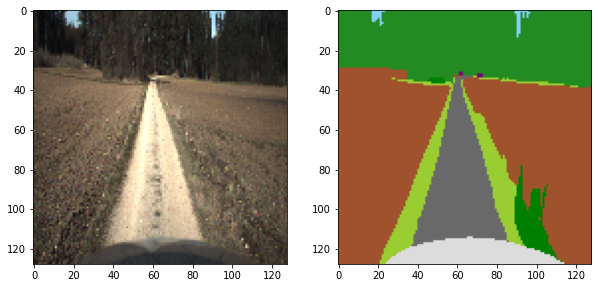

In [10]:
temp = choice(train_pair)
img = img_to_array(load_img(temp[0], target_size=(img_size,img_size)))
mask = img_to_array(load_img(temp[1], target_size = (img_size,img_size)))
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img/255)
plt.subplot(122)
plt.imshow(mask/255)

In [12]:
class_map_df = pd.read_csv("class_dict.csv")

In [13]:
class_map = []
for index,item in class_map_df.iterrows():
    class_map.append(np.array([item['r'], item['g'], item['b']]))
    
len(class_map)

24

In [15]:
def form_2D_label(mask,class_map):
    mask = mask.astype("uint8")
    label = np.zeros(mask.shape[:2],dtype= np.uint8)
    
    for i, rgb in enumerate(class_map):
        label[(mask == rgb).all(axis=2)] = i
    
    return label

In [16]:
lab = form_2D_label(mask,class_map)
np.unique(lab,return_counts=True)

(array([ 1,  2,  5,  6,  7, 16, 17, 22], dtype=uint8),
 array([1951, 7464, 4246, 1341,  449,   71,   10,  852], dtype=int64))

In [17]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, pair, class_map, batch_size=16, dim=(224,224,3), shuffle=True):
        'Initialization'
        self.dim = dim
        self.pair = pair
        self.class_map = class_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.pair) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.pair))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.pair[i][0] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)

            label = load_img(self.pair[i][1],target_size=self.dim)
            label = img_to_array(label)
            label = form_2D_label(label,self.class_map)
            label = to_categorical(label , num_classes = 32)
            batch_labels.append(label)
            
        return np.array(batch_imgs) ,np.array(batch_labels)

In [18]:
train_generator = DataGenerator(train_pair+test_pair,class_map,batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
train_steps = train_generator.__len__()
train_steps

110

In [19]:
X,y = train_generator.__getitem__(1)
y.shape

(4, 128, 128, 32)

In [20]:
val_generator = DataGenerator(val_pair, class_map, batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
val_steps = val_generator.__len__()
val_steps

25

In [21]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(h, w, filters):
# down
    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    output_layer = Conv2D(filters=32, kernel_size=(1, 1), activation='softmax')(deconv9)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [22]:
model = Unet(img_size , img_size , 64)
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________________

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=['accuracy'])

In [24]:
mc = ModelCheckpoint(mode='max', filepath='top-weights.h5', monitor='val_acc',save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_acc', patience=10, verbose=0)
tb = TensorBoard(log_dir="logs/", histogram_freq=0, write_graph=True, write_images=False)
rl = ReduceLROnPlateau(monitor='val_acc',factor=0.1,patience=5,verbose=1,mode="max",min_lr=0.0001)
cv = CSVLogger("logs/log.csv" , append=True , separator=',')

In [25]:
results = model.fit_generator(train_generator , steps_per_epoch=train_steps ,epochs=100,
                              validation_data=val_generator,validation_steps=val_steps,callbacks=[mc,es,tb,rl,cv])

C:\Python\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
110/110 [==============================] - 492s 4s/step - loss: 1.7709 - accuracy: 0.5032 - val_loss: 4.2437 - val_accuracy: 0.3321
Epoch 2/100
110/110 [==============================] - 473s 4s/step - loss: 1.3171 - accuracy: 0.5893 - val_loss: 1.9550 - val_accuracy: 0.4452
Epoch 3/100
110/110 [==============================] - 469s 4s/step - loss: 1.2017 - accuracy: 0.6154 - val_loss: 1.2854 - val_accuracy: 0.6008
Epoch 4/100
110/110 [==============================] - 470s 4s/step - loss: 1.1486 - accuracy: 0.6285 - val_loss: 1.0913 - val_accuracy: 0.6424
Epoch 5/100
110/110 [==============================] - 469s 4s/step - loss: 1.1238 - accuracy: 0.6357 - val_loss: 1.0713 - val_accuracy: 0.6523
Epoch 6/100
110/110 [==============================] - 467s 4s/step - loss: 1.0711 - accuracy: 0.6519 - val_loss: 0.9985 - val_accuracy: 0.6639
Epoch 7/100
110/110 [==============================] - 470s 4s/step - loss: 1.0673 - accuracy: 0.6513 - val_loss: 1.0462 - val_accuracy:

Epoch 17/100
110/110 [==============================] - 467s 4s/step - loss: 0.8505 - accuracy: 0.7226 - val_loss: 0.7765 - val_accuracy: 0.7363
Epoch 18/100
110/110 [==============================] - 468s 4s/step - loss: 0.8358 - accuracy: 0.7263 - val_loss: 0.8055 - val_accuracy: 0.7283
Epoch 19/100
110/110 [==============================] - 469s 4s/step - loss: 0.8445 - accuracy: 0.7230 - val_loss: 0.8135 - val_accuracy: 0.7350
Epoch 20/100
110/110 [==============================] - 469s 4s/step - loss: 0.8156 - accuracy: 0.7319 - val_loss: 0.7982 - val_accuracy: 0.7370
Epoch 21/100
110/110 [==============================] - 466s 4s/step - loss: 0.7988 - accuracy: 0.7412 - val_loss: 0.8192 - val_accuracy: 0.7162
Epoch 22/100
110/110 [==============================] - 466s 4s/step - loss: 0.7861 - accuracy: 0.7406 - val_loss: 0.9131 - val_accuracy: 0.6920
Epoch 23/100
110/110 [==============================] - 466s 4s/step - loss: 0.7807 - accuracy: 0.7423 - val_loss: 0.7191 - val_ac

Epoch 32/100
110/110 [==============================] - 615s 6s/step - loss: 0.6708 - accuracy: 0.7805 - val_loss: 0.7538 - val_accuracy: 0.7503
Epoch 33/100
110/110 [==============================] - 550s 5s/step - loss: 0.6643 - accuracy: 0.7845 - val_loss: 0.6840 - val_accuracy: 0.7725
Epoch 34/100
110/110 [==============================] - 492s 4s/step - loss: 0.6575 - accuracy: 0.7846 - val_loss: 0.7820 - val_accuracy: 0.7318
Epoch 35/100
110/110 [==============================] - 497s 5s/step - loss: 0.6341 - accuracy: 0.7936 - val_loss: 0.6956 - val_accuracy: 0.7634
Epoch 36/100
110/110 [==============================] - 506s 5s/step - loss: 0.6292 - accuracy: 0.7956 - val_loss: 0.7019 - val_accuracy: 0.7700
Epoch 37/100
110/110 [==============================] - 487s 4s/step - loss: 0.6042 - accuracy: 0.8031 - val_loss: 0.6588 - val_accuracy: 0.7848
Epoch 38/100
110/110 [==============================] - 500s 5s/step - loss: 0.6012 - accuracy: 0.8047 - val_loss: 0.7875 - val_ac

Epoch 48/100
110/110 [==============================] - 499s 5s/step - loss: 0.5127 - accuracy: 0.8340 - val_loss: 0.6341 - val_accuracy: 0.7940
Epoch 49/100
110/110 [==============================] - 510s 5s/step - loss: 0.4900 - accuracy: 0.8421 - val_loss: 0.7458 - val_accuracy: 0.7535
Epoch 50/100
110/110 [==============================] - 511s 5s/step - loss: 0.4820 - accuracy: 0.8433 - val_loss: 0.6303 - val_accuracy: 0.7991
Epoch 51/100
110/110 [==============================] - 503s 5s/step - loss: 0.4761 - accuracy: 0.8451 - val_loss: 0.6030 - val_accuracy: 0.8011
Epoch 52/100
110/110 [==============================] - 510s 5s/step - loss: 0.4645 - accuracy: 0.8489 - val_loss: 0.7238 - val_accuracy: 0.7797
Epoch 53/100
110/110 [==============================] - 523s 5s/step - loss: 0.4514 - accuracy: 0.8537 - val_loss: 0.6644 - val_accuracy: 0.7860
Epoch 54/100
110/110 [==============================] - 519s 5s/step - loss: 0.4559 - accuracy: 0.8533 - val_loss: 0.6782 - val_ac

Epoch 63/100
110/110 [==============================] - 465s 4s/step - loss: 0.4008 - accuracy: 0.8691 - val_loss: 0.7004 - val_accuracy: 0.7830
Epoch 64/100
110/110 [==============================] - 463s 4s/step - loss: 0.3931 - accuracy: 0.8726 - val_loss: 0.6629 - val_accuracy: 0.7994
Epoch 65/100
110/110 [==============================] - 466s 4s/step - loss: 0.3804 - accuracy: 0.8758 - val_loss: 0.5847 - val_accuracy: 0.8149
Epoch 66/100
110/110 [==============================] - 463s 4s/step - loss: 0.3605 - accuracy: 0.8834 - val_loss: 0.6051 - val_accuracy: 0.8115
Epoch 67/100
110/110 [==============================] - 465s 4s/step - loss: 0.3536 - accuracy: 0.8845 - val_loss: 0.6052 - val_accuracy: 0.8139
Epoch 68/100
110/110 [==============================] - 463s 4s/step - loss: 0.3351 - accuracy: 0.8897 - val_loss: 0.6460 - val_accuracy: 0.7946
Epoch 69/100
110/110 [==============================] - 464s 4s/step - loss: 0.3528 - accuracy: 0.8836 - val_loss: 0.7006 - val_ac

Epoch 79/100
110/110 [==============================] - 465s 4s/step - loss: 0.2894 - accuracy: 0.9046 - val_loss: 0.5665 - val_accuracy: 0.8322
Epoch 80/100
110/110 [==============================] - 467s 4s/step - loss: 0.2989 - accuracy: 0.9007 - val_loss: 0.6404 - val_accuracy: 0.8187
Epoch 81/100
110/110 [==============================] - 465s 4s/step - loss: 0.2843 - accuracy: 0.9059 - val_loss: 0.6227 - val_accuracy: 0.8183
Epoch 82/100
110/110 [==============================] - 463s 4s/step - loss: 0.2970 - accuracy: 0.9012 - val_loss: 0.6850 - val_accuracy: 0.8005
Epoch 83/100
110/110 [==============================] - 463s 4s/step - loss: 0.2844 - accuracy: 0.9059 - val_loss: 0.5997 - val_accuracy: 0.8254
Epoch 84/100
110/110 [==============================] - 465s 4s/step - loss: 0.2881 - accuracy: 0.9042 - val_loss: 0.6376 - val_accuracy: 0.8151
Epoch 85/100
110/110 [==============================] - 465s 4s/step - loss: 0.2670 - accuracy: 0.9111 - val_loss: 0.5856 - val_ac

Epoch 94/100
110/110 [==============================] - 464s 4s/step - loss: 0.2724 - accuracy: 0.9085 - val_loss: 0.6593 - val_accuracy: 0.8168
Epoch 95/100
110/110 [==============================] - 463s 4s/step - loss: 0.2412 - accuracy: 0.9192 - val_loss: 0.6021 - val_accuracy: 0.8265
Epoch 96/100
110/110 [==============================] - 465s 4s/step - loss: 0.2353 - accuracy: 0.9207 - val_loss: 0.5882 - val_accuracy: 0.8305
Epoch 97/100
110/110 [==============================] - 462s 4s/step - loss: 0.2253 - accuracy: 0.9244 - val_loss: 0.5783 - val_accuracy: 0.8361
Epoch 98/100
110/110 [==============================] - 463s 4s/step - loss: 0.2226 - accuracy: 0.9252 - val_loss: 0.6036 - val_accuracy: 0.8292
Epoch 99/100
110/110 [==============================] - 463s 4s/step - loss: 0.2222 - accuracy: 0.9252 - val_loss: 0.5802 - val_accuracy: 0.8348
Epoch 100/100
110/110 [==============================] - 465s 4s/step - loss: 0.2431 - accuracy: 0.9179 - val_loss: 0.6168 - val_a

In [26]:
img_mask = choice(val_pair)
img= img_to_array(load_img(img_mask[0] , target_size= (img_size,img_size)))
gt_img = img_to_array(load_img(img_mask[1] , target_size= (img_size,img_size)))

In [27]:
def make_prediction(model,img_path,shape):
    img= img_to_array(load_img(img_path , target_size= shape))/255.
    img = np.expand_dims(img,axis=0)
    labels = model.predict(img)
    labels = np.argmax(labels[0],axis=2)
    return labels

In [28]:
pred_label = make_prediction(model, img_mask[0], (img_size,img_size,3))
pred_label.shape

(128, 128)

In [29]:
def form_colormap(prediction,mapping):
    h,w = prediction.shape
    color_label = np.zeros((h,w,3),dtype=np.uint8)    
    color_label = mapping[prediction]
    color_label = color_label.astype(np.uint8)
    return color_label

In [30]:
pred_colored = form_colormap(pred_label,np.array(class_map))

Text(0.5, 1.0, 'predicted labels')

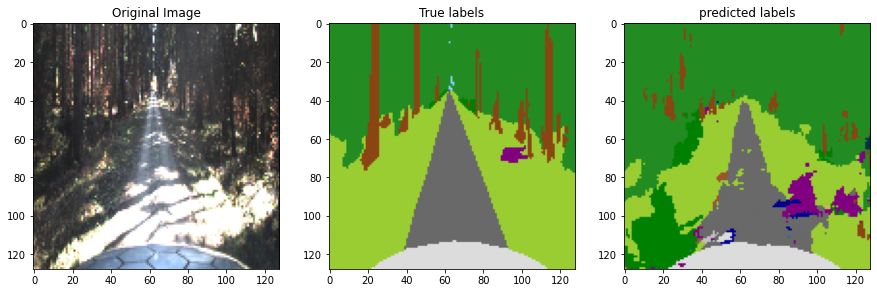

In [32]:
plt.figure(figsize=(15,15))
plt.subplot(131);plt.title('Original Image')
plt.imshow(img/255.)
plt.subplot(132);plt.title('True labels')
plt.imshow(gt_img/255.)
plt.subplot(133)
plt.imshow(pred_colored/255.);plt.title('predicted labels')

In [33]:
# serialize model to JSON
model_json = model.to_json()
with open("./model/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./model/model.h5")
print("Saved model to disk")

Saved model to disk


In [38]:
# load json and create model
from keras.models import model_from_json

json_file = open('./model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./model/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [62]:
img_mask = choice(val_pair)
img= img_to_array(load_img(img_mask[0] , target_size= (img_size,img_size)))
gt_img = img_to_array(load_img(img_mask[1] , target_size= (img_size,img_size)))

In [63]:
pred_label = make_prediction(loaded_model, img_mask[0], (img_size,img_size,3))
pred_label.shape

(128, 128)

In [64]:
pred_colored = form_colormap(pred_label,np.array(class_map))

Text(0.5, 1.0, 'predicted labels')

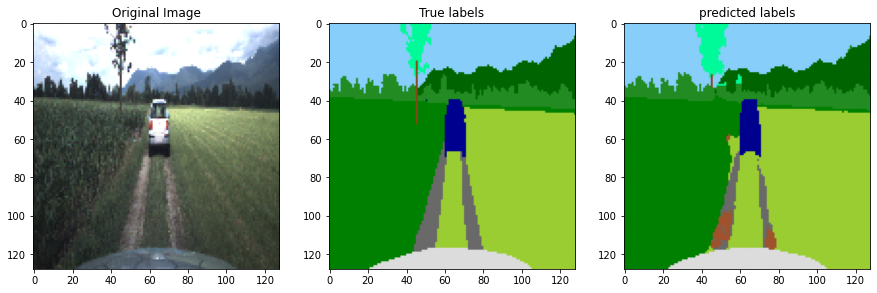

In [65]:
plt.figure(figsize=(15,15))
plt.subplot(131);plt.title('Original Image')
plt.imshow(img/255.)
plt.subplot(132);plt.title('True labels')
plt.imshow(gt_img/255.)
plt.subplot(133)
plt.imshow(pred_colored/255.);plt.title('predicted labels')